### Predict Sahel rainfall with LSTM/fc models: Ensemble

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

Here, we will try to **predict future** Sahel rainfall (lead times 1 / 3 / 6 months) from current and past information (t<=0) of all input features (including PREC_SAHEL) with **LSTM/fc** models.

As extension to former experiments with LSTM/fc models, we now want to train separate models for each months:

- Train individual LSTM/fc models for each month
- Check performance (mse / correl)
- Combine individual models to have an **ensemble predictor**.

**Note:** We use all inputs (excluding months as additional features) as **multivariate** inputs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from json import dump, load
from pathlib import Path

### Import additional functions:
from predict_sahel_rainfall.plot import bar_color
from predict_sahel_rainfall.preprocessing import prepare_inputs_and_target, get_target_months
from predict_sahel_rainfall.models import set_LSTM_fc

### Prepare inputs and targets: Univariate

Load collection of climate indices directly from GitHub release.
Use the complete preprocessing pipeline function.

In [2]:
## Set common parameters (except ESN and lead time) for data preprocessing:

# Set url to csv file containing CICMoD indices from desired release:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Select target index:
target_index = 'PREC_SAHEL'

# Select all input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# # Select subset of input features:
# input_features = [
#     'PREC_SAHEL',
# ]

# Choose, whether to add months as one-hot encoded features:
add_months = False

# Choose, whether to normalize target index:
norm_target = True

# Specify input length:
input_length = 24

# Specify amount of combined training and validation data relative to test data:
train_test_split = 0.9

# Specify relative amount of combined training and validation used for training:
train_val_split = 0.8

## Optionally choose to scale or normalize input features according to statistics from training data:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_11'

In [3]:
# Set parameters for LSTM/fc model:
LSTM_units = [10,20]
fc_units = [20,10]
fc_activation = 'sigmoid'
output_activation = 'linear'
LSTM_weight_init = 'glorot_uniform'
LSTM_recurrent_init = 'orthogonal'
LSTM_bias_init = 'zeros'
fc_weight_init = 'glorot_uniform'
fc_bias_init = 'zeros'
LSTM_weight_reg = None
LSTM_recurrent_reg = None
LSTM_bias_reg = None
fc_weight_reg = None
fc_bias_reg = None
learning_rate = 0.005
loss_function = 'mse'

In [4]:
# Set choice of ESMs:
ESMs = ['CESM']

# Set choice of lead times:
lead_times = [1]

# Set number of runs per setting:
n_runs = 3

# Set number of training epochs:
n_epochs = 20

# Set batch size:
batch_size = 20

# Get number of input features, depending on whether or not months are addes as additional features:
if add_months:
    n_features = len(input_features) + 12
else:
    n_features = len(input_features)
    
# Check number of input channels:
print('Number of input features:',n_features)

Number of input features: 29


In [25]:
## Initializs storages for loss curves and correlation, dimension (#ESMs, #lead times, #months, #runs, #epochs+1).
## Need #epochs+1, since we want to store results for untrained model plus after each epoch.
train_loss_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))
val_loss_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))
test_loss_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))
train_correl_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))
val_correl_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))
test_correl_all = np.zeros((len(ESMs),len(lead_times),12,n_runs,n_epochs+1))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    # Get current ESM:
    ESM = ESMs[m]
    
    # Print status:
    print('ESM:',m+1,'of',len(ESMs))

    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        # Get current lead time:
        lead_time = lead_times[l]
        
        # Print status:
        print('  lead time:',l+1,'of',len(lead_times))

        # Prepare inputs and target for current ESM and lead time:
        (
            train_input,
            train_target,
            val_input,
            val_target,
            test_input,
            test_target,
            train_mean,
            train_std,
            train_min,
            train_max,
        ) = prepare_inputs_and_target(    
            data_url=data_url,
            ESM=ESM,
            target_index=target_index,
            input_features=input_features,
            add_months=add_months,
            norm_target=norm_target,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
            scale_norm=scale_norm,
        )
        
        # Get target months for current ESM and lead time:
        (
            train_months,
            val_months,
            test_months
        ) = get_target_months(
            data_url=data_url,
            ESM=ESM,
            lead_time=lead_time,
            input_length=input_length,
            train_test_split=train_test_split,
            train_val_split=train_val_split,
        )
        
        # Loop over months:
        for i in range(12):
            
            # Get current months (+1):
            month = i+1
            
            # Print status:
            print('    months:',i+1,'of 12')
        
            # Loop over desired number of training runs:
            for r in range(n_runs):

                # Print status:
                print('      run:',r+1,'of',n_runs)

                # Set up CNN/fc model:
                model = set_LSTM_fc(
                    input_length=input_length, 
                    n_features=n_features, 
                    LSTM_units=LSTM_units,
                    fc_units=fc_units, 
                    fc_activation=fc_activation,
                    output_activation=output_activation,
                    LSTM_weight_init=LSTM_weight_init,
                    LSTM_recurrent_init=LSTM_recurrent_init,
                    LSTM_bias_init=LSTM_bias_init,
                    fc_weight_init=fc_weight_init,
                    fc_bias_init=fc_bias_init,
                    LSTM_weight_reg=LSTM_weight_reg,
                    LSTM_recurrent_reg=LSTM_recurrent_reg,
                    LSTM_bias_reg=LSTM_bias_reg,
                    fc_weight_reg=fc_weight_reg,
                    fc_bias_reg=fc_bias_reg,
                    learning_rate=learning_rate, 
                    loss_function=loss_function
                )

                ### Train model: Epoch-by-epoch

                ## Store results for untrained model:

                # Get model predictions on training, validation and test data, ONLY for current month:
                train_pred = model.predict(train_input[train_months==month])
                val_pred = model.predict(val_input[val_months==month])
                test_pred = model.predict(test_input[test_months==month])

                # Compute mse of model predictions vs. true targets, ONLY for current month:
                train_loss = np.mean((train_target[train_months==month]-train_pred)**2)
                val_loss = np.mean((val_target[val_months==month]-val_pred)**2)
                test_loss = np.mean((test_target[test_months==month]-test_pred)**2)

                # Compute correlation coefficient of model predictions vs. true targets, ONLY for current month:
                train_correl = np.corrcoef(np.stack([train_target[train_months==month,0],train_pred[:,0]]))[0,1]
                val_correl = np.corrcoef(np.stack([val_target[val_months==month,0],val_pred[:,0]]))[0,1]
                test_correl = np.corrcoef(np.stack([test_target[test_months==month,0],test_pred[:,0]]))[0,1]

                # Store results:
                train_loss_all[m,l,i,r,0] = train_loss
                val_loss_all[m,l,i,r,0] = val_loss
                test_loss_all[m,l,i,r,0] = test_loss
                train_correl_all[m,l,i,r,0] = train_correl
                val_correl_all[m,l,i,r,0] = val_correl
                test_correl_all[m,l,i,r,0] = test_correl          

                # Loop over epochs:
                for e in range(n_epochs):

                    # Train model for single epoch:
                    history = model.fit(train_input, train_target, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)

                    ## Store results after current epoch:

                    # Get model predictions on training, validation and test data, ONLY for current month:
                    train_pred = model.predict(train_input[train_months==month])
                    val_pred = model.predict(val_input[val_months==month])
                    test_pred = model.predict(test_input[test_months==month])

                    # Compute mse of model predictions vs. true targets, ONLY for current month:
                    train_loss = np.mean((train_target[train_months==month]-train_pred)**2)
                    val_loss = np.mean((val_target[val_months==month]-val_pred)**2)
                    test_loss = np.mean((test_target[test_months==month]-test_pred)**2)

                    # Compute correlation coefficient of model predictions vs. true targets, ONLY for current month:
                    train_correl = np.corrcoef(np.stack([train_target[train_months==month,0],train_pred[:,0]]))[0,1]
                    val_correl = np.corrcoef(np.stack([val_target[val_months==month,0],val_pred[:,0]]))[0,1]
                    test_correl = np.corrcoef(np.stack([test_target[test_months==month,0],test_pred[:,0]]))[0,1]

                    # Store results:
                    train_loss_all[m,l,i,r,e+1] = train_loss
                    val_loss_all[m,l,i,r,e+1] = val_loss
                    test_loss_all[m,l,i,r,e+1] = test_loss
                    train_correl_all[m,l,i,r,e+1] = train_correl
                    val_correl_all[m,l,i,r,e+1] = val_correl
                    test_correl_all[m,l,i,r,e+1] = test_correl          

ESM: 1 of 1
  lead time: 1 of 1
    months: 1 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 2 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 3 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 4 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 5 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 6 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 7 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 8 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 9 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 10 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 11 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3
    months: 12 of 12
      run: 1 of 3
      run: 2 of 3
      run: 3 of 3


In [26]:
# ### Store results:

   
# ## LSTM/fc - multivariate:

# # Specify model setup:
# setup = 'LSTM/fc - multivariate - per month'

# # Save loss and correlation results:
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_train_loss_all.npy', train_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_val_loss_all.npy', val_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_test_loss_all.npy', test_loss_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_train_correl_all.npy', train_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_val_correl_all.npy', val_correl_all)
# np.save('../results/quickrun_LSTM_fc_multivariate_per_month_test_correl_all.npy', test_correl_all)

# # Store parameters:
# parameters = {
#     "setup": setup,
#     "data_url": data_url,
#     "target_index": target_index,
#     "input_features": input_features,
#     "add_months": add_months,
#     "norm_target": norm_target,
#     "input_length": input_length,
#     "train_test_split": train_test_split,
#     "train_val_split": train_val_split,
#     "train_val_split": train_val_split,
#     "scale_norm": scale_norm,    
#     "LSTM_units": LSTM_units,
#     "fc_units": fc_units,
#     "fc_activation": fc_activation,
#     "output_activation": output_activation,
#     "LSTM_weight_init": LSTM_weight_init,
#     "LSTM_recurrent_init": LSTM_recurrent_init,
#     "LSTM_bias_init": LSTM_bias_init,
#     "fc_weight_init": fc_weight_init,
#     "fc_bias_init": fc_bias_init,
#     "LSTM_weight_reg": LSTM_weight_reg,
#     "LSTM_recurrent_reg": LSTM_recurrent_reg,
#     "LSTM_bias_reg": LSTM_bias_reg,
#     "fc_weight_reg": fc_weight_reg,
#     "fc_bias_reg": fc_bias_reg,
#     "learning_rate": learning_rate,
#     "loss_function": loss_function,
#     "ESMs": ESMs,
#     "lead_times": lead_times,
#     "n_runs": n_runs,
#     "n_epochs": n_epochs,
#     "batch_size": batch_size,    
# }

# path_to_store_results = Path('../results')
# with open(path_to_store_results / "quickrun_LSTM_fc_multivariate_per_month_parameters.json", "w") as f:
#     dump(parameters, f)

In [5]:
# ### Reload results:

# ## LSTM/fc - multivariate - per month:

# # Load loss and correlation results:
# train_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_train_loss_all.npy')
# val_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_val_loss_all.npy')
# test_loss_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_test_loss_all.npy',)
# train_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_train_correl_all.npy')
# val_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_val_correl_all.npy')
# test_correl_all = np.load('../results/quickrun_LSTM_fc_multivariate_per_month_test_correl_all.npy')

# # Load parameters:
# path_to_store_results = Path('../results')
# with open(path_to_store_results / 'quickrun_LSTM_fc_multivariate_per_month_parameters.json', 'r') as f:
#     parameters=load(f)

# ESMs = parameters['ESMs']
# lead_times = parameters['lead_times']
# n_runs = parameters['n_runs']
# n_epochs = parameters['n_epochs']


### Postprocessing

We now have loss ('mse') and correlation for complete training, validation and test data after each epoch (starting with untrained model as epoch 0).

Next, we aim to find the **minimum loss and maximum correlation on test data** for the **epoch with minimum validation loss**.
This search is done separately for each ESM, lead time, month and model run.

In a second step, we compute the **mean loss and correlation on test data over all runs**, separately for each ESM, lead time and month.

In [6]:
## Initializs storages for test loss (min) and correlation (max), where val loss takes its minimum,
## dimension (#ESMs, #lead times, #months, #runs).
test_loss_min = np.zeros((len(ESMs),len(lead_times),12,n_runs))
test_correl_max = np.zeros((len(ESMs),len(lead_times),12,n_runs))

## Initializs storages for mean test loss and correlation, averaged over all training runs,
## dimension (#ESMs, #lead times, #months).
test_loss_min_mean = np.zeros((len(ESMs),len(lead_times),12))
test_correl_max_mean = np.zeros((len(ESMs),len(lead_times),12))

## Loop over ESMs:
for m in range(len(ESMs)):
    
    ## Loop over lead times:
    for l in range(len(lead_times)):
        
        ## Loop over months:
        for i in range(12):
        
            # Loop over desired number of training runs:
            for r in range(n_runs):

                # Get epoch with minimum validation loss for current ESM, lead time and training run:
                e_min = np.argmin(val_loss_all[m,l,i,r])

                # Store corresponding test loss and correlation:
                test_loss_min[m,l,i,r] = test_loss_all[m,l,i,r,e_min]
                test_correl_max[m,l,i,r] = test_correl_all[m,l,i,r,e_min]

            # Get mean test loss and correlation over all training runs, for current ESM and lead time:
            test_loss_min_mean[m,l,i] = np.mean(test_loss_min[m,l,i])
            test_correl_max_mean[m,l,i] = np.mean(test_correl_max[m,l,i])

### Results: Multivariate LSTM/fc (per month)

Text(0.5, 1.0, 'CESM, lead 1: Test loss per months')

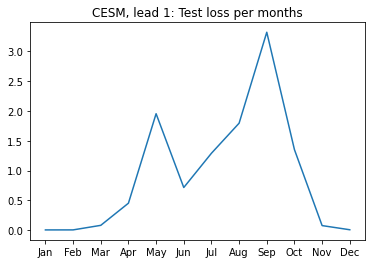

In [18]:
# Set array of months:
months_text = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Plot test loss over months:
plt.plot(months_text,test_loss_min_mean[0,0])
plt.title('CESM, lead 1: Test loss per months')

Text(0.5, 1.0, 'CESM, lead 1: Test correl per months')

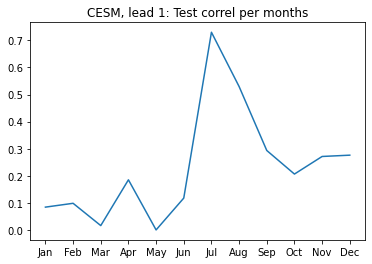

In [17]:
# Plot test correlation over months:
plt.plot(months_text,test_correl_max_mean[0,0])
plt.title('CESM, lead 1: Test correl per months')

In [19]:
# Get mean test loss over all months:
np.mean(test_loss_min_mean)

0.9207288613448128

### Discussion: LSTM / fc models - multivariate - per months

Here, we tried to **predict future** Sahel rainfall (lead times 1 month) from current and past information (t<=0) of all input features (including PREC_SAHEL) from CESM data with **LSTM/fc** models.

We trained separate models for each months.

Interestingly, we find huge differences in the correlation per months: Highest correlation is achieved during the period of interest (Summer Monsoon) and reads 0.7 for July!

The average loss over all months is found to be 0.921 and thus, slightly higher compared to an LSTM/fc model trained on all inputs including months as additional input feature.